In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import joblib


In [2]:
train_df = pd.read_csv("../data/priank/data_train.csv")
test_df = pd.read_csv("../data/priank/data_test.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(400, 12) (100, 12)


,age,gender,symptom_code,urgency,time_of_day,wait_load_A,wait_load_B,wait_load_C,specialty_match_A,specialty_match_B,specialty_match_C,assigned_center
0,53,0,sprain,2,1,8,12,19,0,1,0,Center_B
1,43,1,depression,5,0,10,23,5,0,1,0,Center_B
2,54,0,sprain,3,0,9,9,10,0,1,0,Center_B
3,24,1,burn,3,2,24,6,19,1,0,0,Center_A
4,30,1,stress,1,0,11,15,10,0,0,1,Center_C


In [3]:
X_train = train_df.drop(columns=["assigned_center"])
y_train = train_df["assigned_center"]

X_test = test_df.drop(columns=["assigned_center"])
y_test = test_df["assigned_center"]


In [4]:
# Encode categorical columns
for col in X_train.columns:
    if X_train[col].dtype == "object":
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [5]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [6]:
def inject_label_noise(y, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n = len(y)
    n_noisy = int(noise_level * n)
    noisy_idx = np.random.choice(n, n_noisy, replace=False)
    unique_classes = np.unique(y)
    for i in noisy_idx:
        possible = [c for c in unique_classes if c != y[i]]
        y_noisy[i] = np.random.choice(possible)
    return y_noisy

# Add 10% label noise to training set only
y_train_enc = inject_label_noise(y_train_enc, noise_level=0.7)

In [7]:
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    max_depth=6,
    learning_rate=0.2,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train_enc)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

In [8]:
y_pred = model.predict(X_test)
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_enc, y_pred))


              precision    recall  f1-score   support

    Center_A       0.39      0.44      0.42        34
    Center_B       0.24      0.26      0.25        31
    Center_C       0.39      0.31      0.35        35

    accuracy                           0.34       100
   macro avg       0.34      0.34      0.34       100
weighted avg       0.34      0.34      0.34       100

[[15 11  8]
 [14  8  9]
 [ 9 15 11]]


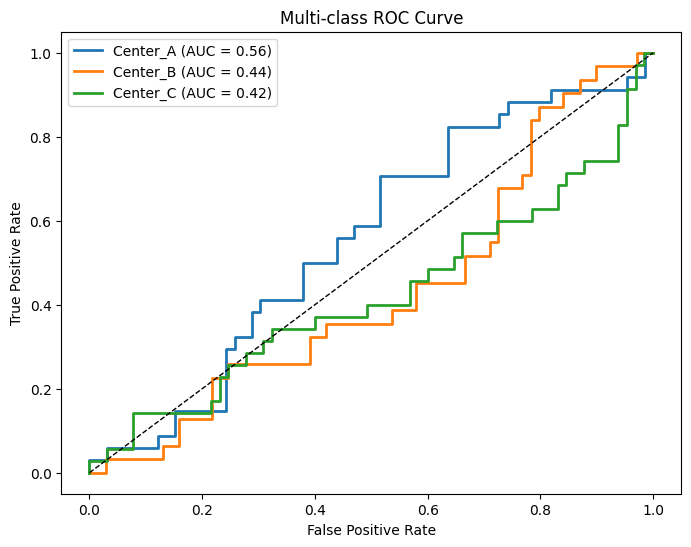

In [9]:
y_proba = model.predict_proba(X_test)
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()


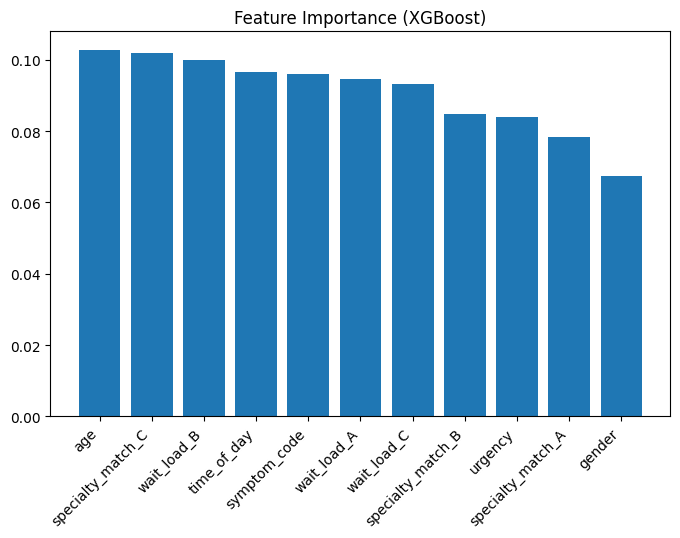

In [10]:
xgb_importances = model.feature_importances_
sorted_idx = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(sorted_idx)), xgb_importances[sorted_idx])
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=45, ha='right')
plt.title("Feature Importance (XGBoost)")
plt.show()


In [ ]:
joblib.dump(model, "backend/models/doctor_routing_model.pkl")
joblib.dump(label_encoder, "backend/models/label_encoder.pkl")

['backend/label_encoder.pkl']

In [14]:
X_train.columns

Index(['age', 'gender', 'symptom_code', 'urgency', 'time_of_day',
       'wait_load_A', 'wait_load_B', 'wait_load_C', 'specialty_match_A',
       'specialty_match_B', 'specialty_match_C'],
      dtype='object')